In [1]:
# Adding utils' path
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
# Importing libraries
from tqdm import tqdm
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoModelForImageClassification,
    ViTFeatureExtractor,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
)
from datasets import load_dataset, Dataset
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training
import evaluate
import random
import numpy as np
import warnings
import os

from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from collections import Counter
import pandas as pd
import json
import matplotlib.pyplot as plt

from utils import parse_args, gather_metrics, plot_metrics, perform_lora_svd, plot_lora_svd_singular_values

# Set warnings to ignore to keep output clean
warnings.filterwarnings('ignore')

/home/rft38/.conda/envs/ML-6784/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Hyperparameters
dataset_type = "stanford-dogs"
shuffle_label_ratio = 0
train_num_classes = None
use_lora = True
lora_rank = 500
lora_alpha, lora_dropout = 2*lora_rank, 0.1
batch_size, eval_batch_size, gradient_accumulation_steps, max_steps = 32, 50, 1, 500

In [4]:
# Dataset selection
if dataset_type == "mnist":
    dataset = load_dataset("mnist")
    num_classes = 10
    label_column_name = 'label'
    image_col_name = "image"

elif dataset_type == "oxford-pet":
    dataset = load_dataset("visual-layer/oxford-iiit-pet-vl-enriched")
    num_classes = 37
    label_column_name = 'label_breed'
    image_col_name = "image"

elif dataset_type == "stanford-dogs":
    dataset = load_dataset("amaye15/stanford-dogs")
    num_classes = 120
    label_column_name = 'label'
    image_col_name = "pixel_values"

else:
    raise ValueError("Currently not supported -> You can add them now")

min_num_classes = 10

# Creating val/train split
dataset = dataset["train"].train_test_split(test_size=0.15, shuffle=True, seed=1)
train_dataset = dataset['train']
val_dataset = dataset['test']

In [68]:
# Preprocessing for the labels -> Only necessary for oxford-pet, not mnist or stanford-dogs
if dataset_type == "oxford-pet":
    label_encoder = LabelEncoder()

    def label_preprocessing(dataset):
        # Fit the encoder on the string labels and transform them to integer labels
        label_encoder.fit(dataset[label_column_name])
        encoded_labels = label_encoder.transform(dataset[label_column_name])

        # Add the encoded labels as a new column in the dataset
        return dataset.add_column('label', encoded_labels)

    # Apply preprocessing
    train_dataset = label_preprocessing(train_dataset)
    val_dataset = label_preprocessing(val_dataset)

In [69]:
# Clamping size of dataset
def clamp_dataset(dataset, num_classes, min_num_classes):
    # Count labels in the training and testing datasets
    label_counts = Counter(dataset['label'])

    sorted_counts = sorted(label_counts.values())
    clamp_value = sum(sorted_counts[:min_num_classes])
    
    per_class_lim = clamp_value // num_classes

    # Group samples by class
    sample_by_class = {}
    for sample in tqdm(dataset, desc="Clamping"):
        cls = sample['label']
        if cls not in sample_by_class:
            sample_by_class[cls] = []

        if len(sample_by_class[cls])<per_class_lim:
            sample_by_class[cls].append(sample)

    clamped_dataset = []
    for samples in sample_by_class.values():
        clamped_dataset += samples

    # Convert back to a Dataset format
    filtered_data = {
        image_col_name: [sample[image_col_name] for sample in clamped_dataset],
        'label': [sample['label'] for sample in clamped_dataset],
    }
    return Dataset.from_dict(filtered_data)

# Filter classes if specified
if train_num_classes:
    selected_classes = train_num_classes

    def filter_classes(batch):
        return batch['label'] in selected_classes

    train_dataset = train_dataset.filter(filter_classes)
    val_dataset = val_dataset.filter(filter_classes)

    # Update num_classes to reflect the number of selected classes
    num_classes = len(selected_classes)

    # Preprocessing for the labels -> Once filtered the labels need to be set between (0, num(classes)-1)
    label_encoder = LabelEncoder()

    def label_preprocessing(dataset):
        # Fit the encoder only on the filtered labels
        label_encoder.fit(selected_classes)
        # Transform the dataset labels
        dataset = dataset.map(lambda batch: {'label': label_encoder.transform([batch['label']])[0]})
        return dataset

    # Apply preprocessing
    train_dataset = label_preprocessing(train_dataset)
    val_dataset = label_preprocessing(val_dataset)

else:
    selected_classes = [i for i in range(num_classes)]

# Clamping train_dataset
train_dataset = clamp_dataset(train_dataset, num_classes, min_num_classes)

# Preprocessing dataset to be compatible with ViT
transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

# Combined function to resize, convert to RGB, and then to tensor
def preprocess_images(batch):
    batch['pixel_values'] = [transform(image.convert("RGB")) for image in batch[image_col_name]]
    if image_col_name!='pixel_values':
        del batch[image_col_name]
    return batch

# Apply resizing
train_dataset = train_dataset.map(preprocess_images, batched=True)
val_dataset = val_dataset.map(preprocess_images, batched=True)

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 777/777 [00:31<00:00, 24.66 examples/s]


In [ ]:
# To shuffle portion of labels
def shuffle_labels(dataset, shuffle_fraction):
    # Calculate the number of labels to shuffle
    num_samples = len(dataset)
    num_to_shuffle = int(num_samples * shuffle_fraction)
    print(f"Shuffling {num_to_shuffle}/{num_samples} labels.")

    if num_to_shuffle==0:
        return dataset
    
    # Randomly select indices to shuffle
    indices_to_shuffle = random.sample(range(num_samples), num_to_shuffle)

    # Shuffle the selected labels
    shuffled_labels = [dataset[i]['label'] for i in indices_to_shuffle]
    random.shuffle(shuffled_labels)

    shuffled_dataset = {'pixel_values': [], 'label': []}
    for i, sample in tqdm(enumerate(dataset), desc="Shuffling"):
        if i in indices_to_shuffle:
            new_label = shuffled_labels.pop(0)
            sample['label'] = new_label

        shuffled_dataset['pixel_values'].append(sample['pixel_values'])
        shuffled_dataset['label'].append(sample['label'])

    return Dataset.from_dict(shuffled_dataset)

# Shuffle 'em labels in train
new_dataset = shuffle_labels(train_dataset, shuffle_label_ratio)

Shuffling 155/777 labels.


Shuffling: 777it [00:48, 15.89it/s]


In [ ]:
# Setup LoRA
if use_lora:
    layers = ["query", "key", "value"]
    target_modules = [f"vit.encoder.layer.{i}.attention.attention.{layer}" for i in range(0, 12) for layer in layers]

    # Set up LoRA configuration
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        target_modules=target_modules,
        lora_dropout=lora_dropout,
        use_rslora=True,
    )

# Load model and tokenizer
model_name = "google/vit-base-patch16-224" 
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels = num_classes, ignore_mismatched_sizes=True)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Apply LoRA to the model
if use_lora:
    model = get_peft_model(model, lora_config)

# Move model to GPU
model = model.to("cuda")

# Define accuracy metric
accuracy = evaluate.load("accuracy")

# Define the compute_metrics function to calculate accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([120]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([120, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Init run
run_name = "ViT"
training_args = TrainingArguments(
    output_dir=f"results/{run_name}",
    per_device_train_batch_size= batch_size,
    per_device_eval_batch_size= eval_batch_size,
    label_names = ["labels"],
    gradient_accumulation_steps= gradient_accumulation_steps,
    max_steps=max_steps,
    logging_steps=20,
    eval_steps=20,
    save_steps=20,
    save_total_limit=1,
    evaluation_strategy="steps",
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss,Accuracy
10,4.758700,4.603747,0.075891
20,4.505400,4.283781,0.154095
30,4.126400,3.911802,0.264692
40,3.731000,3.533613,0.357242
50,3.456600,3.202924,0.422490
60,3.132200,2.879133,0.523369
70,2.669000,2.658231,0.517816
80,2.564100,2.396672,0.564553
90,2.278800,2.208695,0.619158
100,2.162900,2.047701,0.637668


TrainOutput(global_step=500, training_loss=1.4934551811218262, metrics={'train_runtime': 9352.2198, 'train_samples_per_second': 1.711, 'train_steps_per_second': 0.053, 'total_flos': 1.6395877479167263e+18, 'train_loss': 1.4934551811218262, 'epoch': 1.3054830287206267})

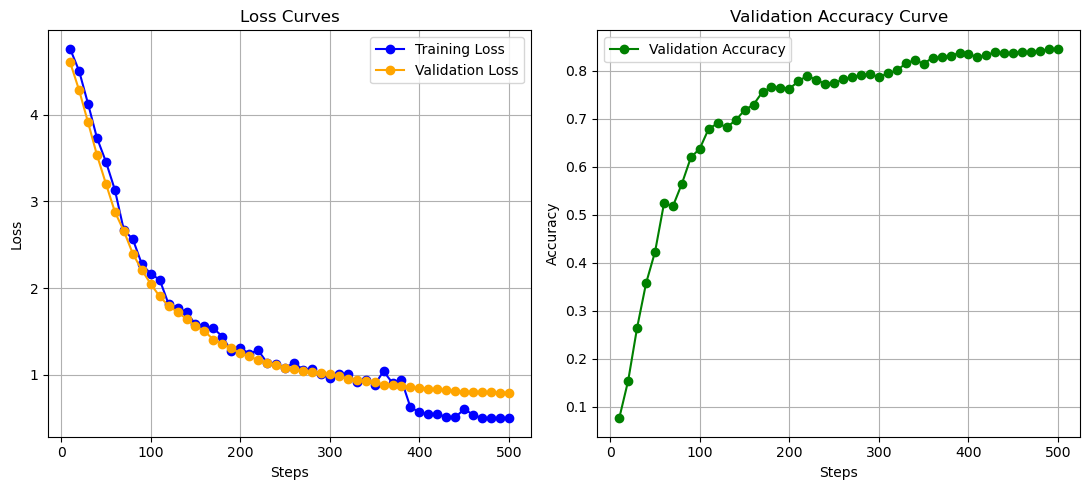

In [80]:
# Gather data from trainer and plot
data = gather_metrics(trainer)
plot_metrics(data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.07it/s]


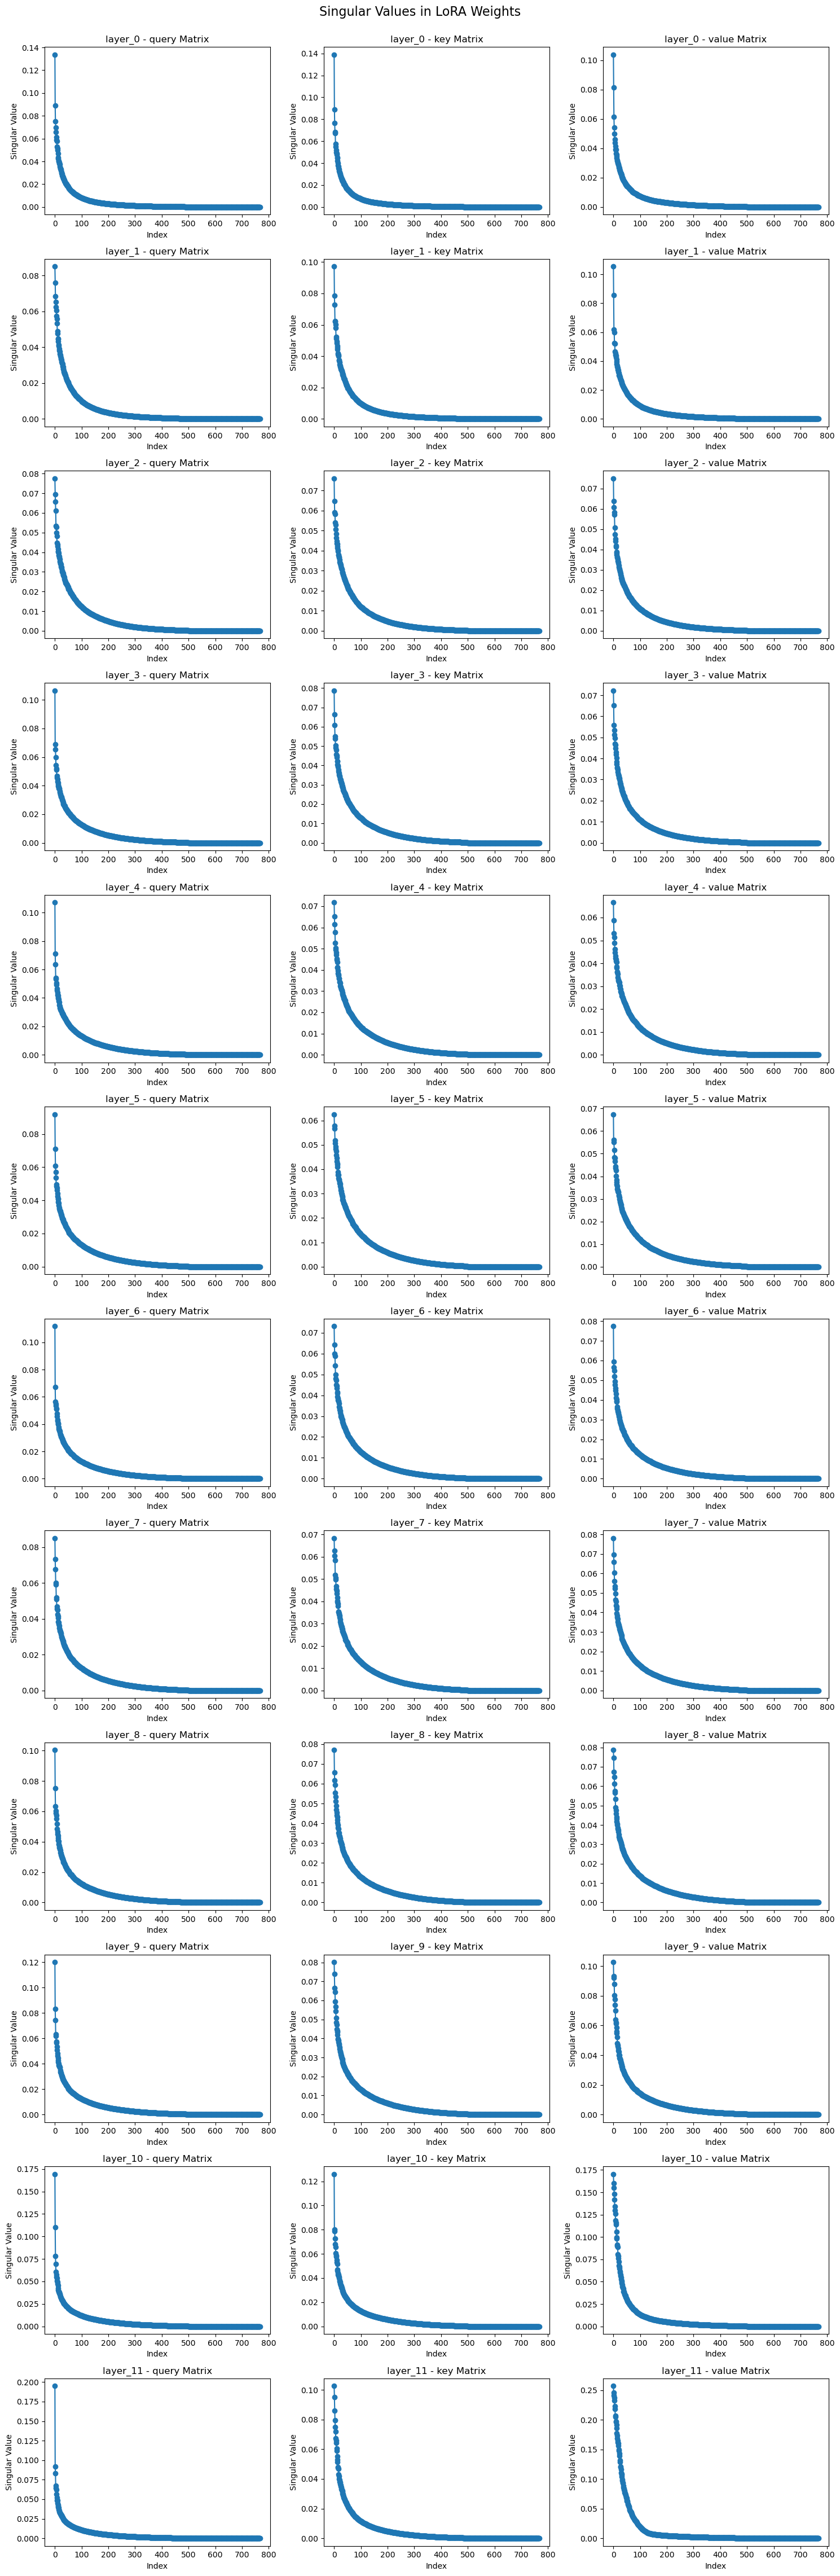

In [169]:
# If LoRA, then extract the diagonal entries for singular value decomposition
svd_diagonal_entries = perform_lora_svd(model)
plot_lora_svd_singular_values(svd_diagonal_entries)